# Table of contents

1. [PCA](#PCA)
2. [PCA - dataframe seperated into cell lines](#PCA_cell_line)
3. [PCA - dataframe seperated into states](#PCA_states)
4. [PCA - dataframe seperated into cell line and state](#PCA_cell_line_and_states)
5. [Batch effect investigation](#Batch_effect_investigation)
6. [Intensity histogram](#Intensity_histogram)
7. [Intensity histogram - A549 Surviving cells](#Intensity_histogram_A549_surviving_cells)
8. [Intensity histrogram - A549 dead cells](#Intensity_histogram_A549_dead_cells)
9. [Intensity histrogram - RKO surviving cells](#Intensity_histogram_RKO_surviving_cells)
10. [Intensity histrogram - RKO dead cells](#Intensity_histogram_RKO_dead_cells) 
11. [Intensity histrogram - MCF7 surviving cells](#Intensity_histogram_MCF7_surviving_cells) 
12. [Intensity histrogram - MCF7 dead cells](#Intensity_histogram_MCF7_dead_cells) 






In [3]:
import os 
import pandas as pd
import numpy as np

from get_columns import get_cell_line_state_replicate, get_base_cols_proteinGroups, get_all_peptide_counts, get_razor_and_unique_peptide_counts, get_unique_peptides, get_sequence_coverage, get_all_reporter_intensity_correct, get_reporter_intensity_without_control
from column_mapper import col_to_treatment_mapper, treatment_nomenclature_map_dict, col_to_cell_line_mapper, col_to_state_mapper, col_to_rep_mapper
pd.options.mode.chained_assignment = None
os.chdir("/home/ptruong/git/lifeAndDeath/data/amirata")
df = pd.read_csv("proteinGroups tryptic.csv", sep = "\t")

/home/ptruong/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (726,727) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:

cell_lines, states, replicates = get_cell_line_state_replicate()

base_cols = get_base_cols_proteinGroups()
peptide_count_cols = get_all_peptide_counts()
#razor_and_unique_peptides_cols = get_razor_and_unique_peptide_counts()
#unique_peptides_cols = get_unique_peptides()
sequence_coverage_cols = get_sequence_coverage()
reporter_intensity_corrected_cols = get_all_reporter_intensity_correct()

In [5]:

def select_rep_state_intensities(rep, state):
    intensity_list = []
    for i in reporter_intensity_corrected_cols:
        if i.split(" ")[4].split("_")[2] == ("Rep" + str(rep)):
            if i.split(" ")[4].split("_")[1] == state:
                intensity_list.append(i)
    return intensity_list

def select_rep_state_cell_line_intensities(rep, state, cell_line):
    intensity_list = []
    for i in reporter_intensity_corrected_cols:
        if i.split(" ")[4].split("_")[2] == ("Rep" + str(rep)):
            if i.split(" ")[4].split("_")[1] == state:
                if i.split(" ")[4].split("_")[0] == cell_line:
                    intensity_list.append(i)
    return intensity_list


## Tresholding based on peptide count and sequence coverage

We then make dataframes and define functions so we can treshold the data based on peptide count and sequence coverage.

In [6]:

df_base = df[get_base_cols_proteinGroups()]
df_peptide_count = df[peptide_count_cols]
df_sequence_coverage = df[sequence_coverage_cols]

In [7]:
def apply_peptide_count_treshold(df_subset, treshold = 1):
    for i in df_subset.columns:
        col = "Peptides " + i.split(" ")[-1]
        peptide_count = df_peptide_count[col]
        peptide_count_treshold_boolean_array = (peptide_count > treshold)
        df_subset[i] = df_subset[i] * peptide_count_treshold_boolean_array
    return df_subset

def apply_sequence_coverage_treshold(df_subset, treshold = 0):
    for i in df_subset.columns:
        col = "Sequence coverage " + i.split(" ")[-1] + " [%]"
        sequence_coverage = df_sequence_coverage[col]
        sequence_coverage_treshold_boolean_array = (sequence_coverage > treshold)
        df_subset[i] = df_subset[i] * sequence_coverage_treshold_boolean_array
    return df_subset

def apply_treshold(df_subset, peptide_count_treshold = 1, sequence_coverage_percentage_treshold = 0):
    df_subset = apply_peptide_count_treshold(df_subset, peptide_count_treshold)
    df_subset = apply_sequence_coverage_treshold(df_subset, sequence_coverage_percentage_treshold)
    return df_subset

def subtract_df_with_col(df, col):
    """
    test to see results:
    a = pd.DataFrame(np.array([[1,1,1],[2,4,8],[3,6,9]]).T, columns = ["a", "b", "c"])
    (a.T - a.a).T
    subtract_df_with_col(a, "a")
    """
    return (df.T - df[col]).T

def compute_control_to_treated_fc(df_subset):
    control_col = df_subset.columns[0]
    fc = subtract_df_with_col(df_subset, control_col)
    return fc


def get_df_with_control_vs_treated_fc(df_t):
    """
    df_t is tresholded and logged df with all reporter_intensity_corrected_cols
    """
    df_fc = pd.DataFrame()
    for cell_line in cell_lines:
        for state in states:
            for replicate in replicates:
                df_subset = df_t[select_rep_state_cell_line_intensities(replicate, state, cell_line)]            
                fc = compute_control_to_treated_fc(df_subset)
                if df_fc.empty:
                    df_fc = df_fc.append(fc)
                else:
                    df_fc = df_fc.join(fc)
    return df_fc

## Tresholding parameters

We define peptide count and sequence coverage (%) treshold and perform the filtering below. We also remove the control samples from the data to be analyzed using scikit.

In [8]:

peptide_count_treshold = 1
sequence_coverage_percentage_treshold = 0

df_t = apply_treshold(df[reporter_intensity_corrected_cols], peptide_count_treshold, sequence_coverage_percentage_treshold)
df_t = df_t.replace({0:np.nan})
df_t = np.log2(df_t)
df_res = df_base.join(df_t)

# Q-value treshold
df_res = df_res[df_res["Q-value"] < 0.05] # We needed to do this step to treshold for q-values. perhaps could have done earlier?

# This is the data matrix we work with.
df_int = df_res[get_reporter_intensity_without_control()]
df_int = df_int.T
df_int_proteins = df_int.columns

# Defining targets

We create mapper function so that we can use different targets for our analysis.

In [9]:

# Map columns so we can plot 
df_int["treatment_num"] = df_int.index.map(col_to_treatment_mapper)
df_int["treatment_name"] = df_int.treatment_num.map(treatment_nomenclature_map_dict)
df_int["cell_line"] = df_int.index.map(col_to_cell_line_mapper)
df_int["state"] = df_int.index.map(col_to_state_mapper)
df_int["rep"] = df_int.index.map(col_to_rep_mapper)

## PCA <a name="PCA"></a>


In [10]:

#######
# PCA #
#######

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.multivariate.pca import PCA as wPCA

In [23]:

def pca_plot_ax(axes, row, col, df_int, classification = "state", marker = "rep", seperator = "cell_line", seperate_by = "A549",
            title = None):
    # splice df_int for pca now
    df_pca = df_int[df_int[seperator] == seperate_by]
    df_pca = df_pca.fillna(0)
    #weights = df_pca.notna()*1
    
    features = df_int_proteins
    
    # Separating out the features
    x = df_pca.loc[:, features].values
    
    # Separating out the target
    # classification = "state # Choose target - treatment, cell_line, state here
    # marker = "rep" #marker
    # y = df_pca.loc[:,[classification]].values
    
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    
    # Missing value impuration
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = 0)
    x = imputer.fit_transform(x)
    
    # pca
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df_pca[[classification]].reset_index()[classification]], axis = 1)
    if marker != False:
        finalDf = pd.concat([finalDf, df_pca[[marker]].reset_index()[marker]], axis = 1)
        
    #Visualization
    #fig, ax = plt.subplots(figsize=(16,10))
    if marker != False:
        sns.scatterplot(ax=axes[row,col] , data = finalDf, x = "principal component 1", y = "principal component 2", 
                        hue = classification, style = marker, s = 100)
    else:
        sns.scatterplot(ax=axes[row,col], data = finalDf, x = "principal component 1", y = "principal component 2", 
                hue = classification, s = 100)
    axes[row, col].set_title(seperate_by)

# PCA - dataframe seperated into cell lines <a name="PCA_cell_line"></a>

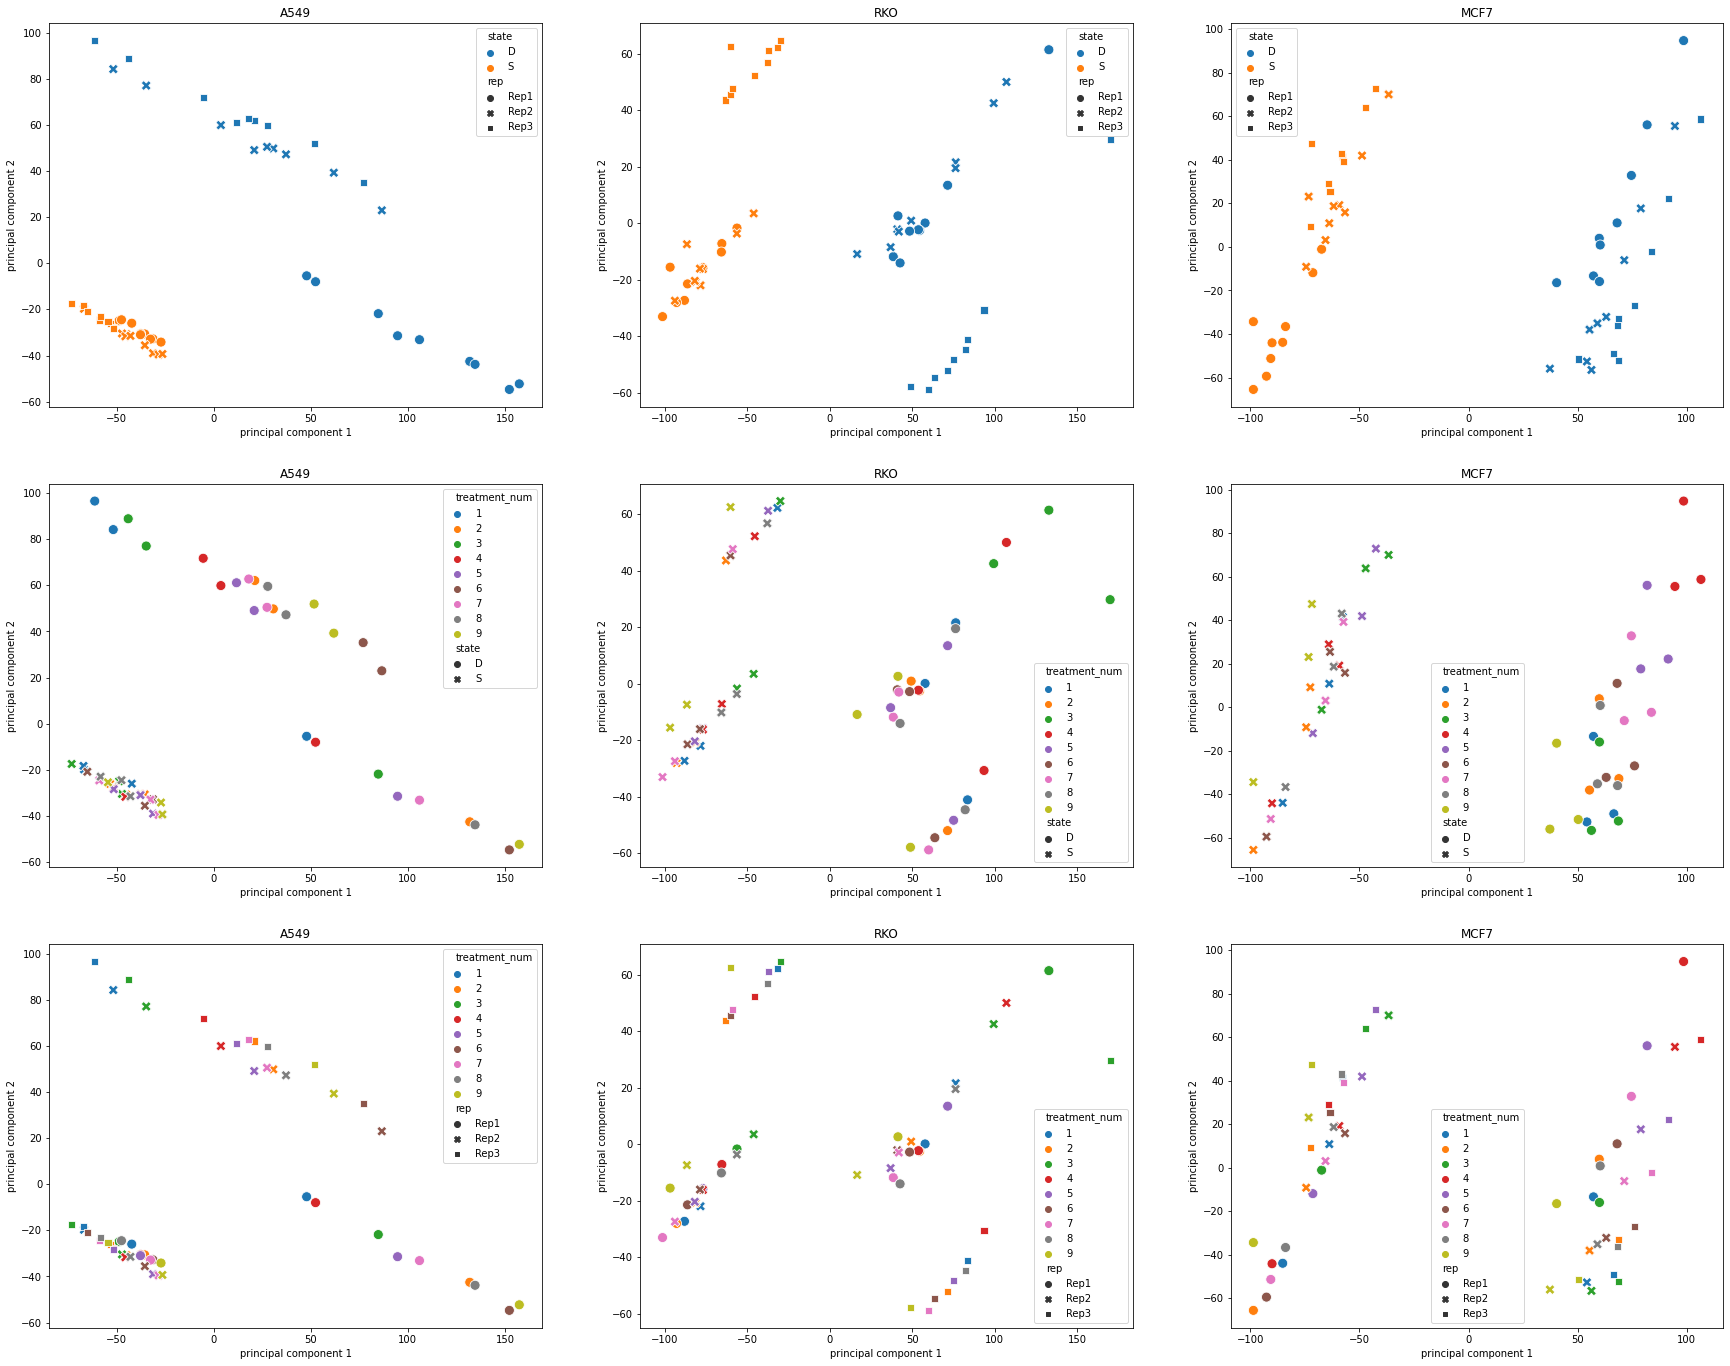

In [25]:
fig, axes = plt.subplots(3, 3, figsize = (30,24))

cell_lines = ["A549", "RKO", "MCF7"]
color_markers = [["state", "rep"], ["treatment_num", "state"], ["treatment_num", "rep"]]
for row in range(3):
    color_marker = color_markers[row]
    for col in range(3):
        cell_line = cell_lines[col]
        pca_plot_ax(axes, row, col, df_int, classification = color_marker[0], marker = color_marker[1], seperator = "cell_line",
                    seperate_by = cell_line, title = None)
    

PCA : A549 seperated on coloured on states (S/D) and marked on replicates. We have good seperation between alive and dead cells. Dead cells from Replicate 1 seems to have significant batch effect. 

Same plot as above. Now we are interested in classifying the treatments. Within the different groups 8-azaguanine and Topotecan seems to frequently end up in the left side. 

Clear seperation of alive and dead cells. RKO Dead and surviving cells from rep3 has significant batch effects .

Same plot as above but coloured on treatment. Bortezomib seem to frequently end up to the left within the groups.

MCF7 has clear seperation between surviving and dead cells. 

Bortezomib seem to end up on the left within the groups

Seems like the PCA seperate well between Surviving and dead dells for all cell lines. Some treatments can frequently be found clustered within groups.

# PCA - dataframe seperated into states <a name="PCA_states"></a>

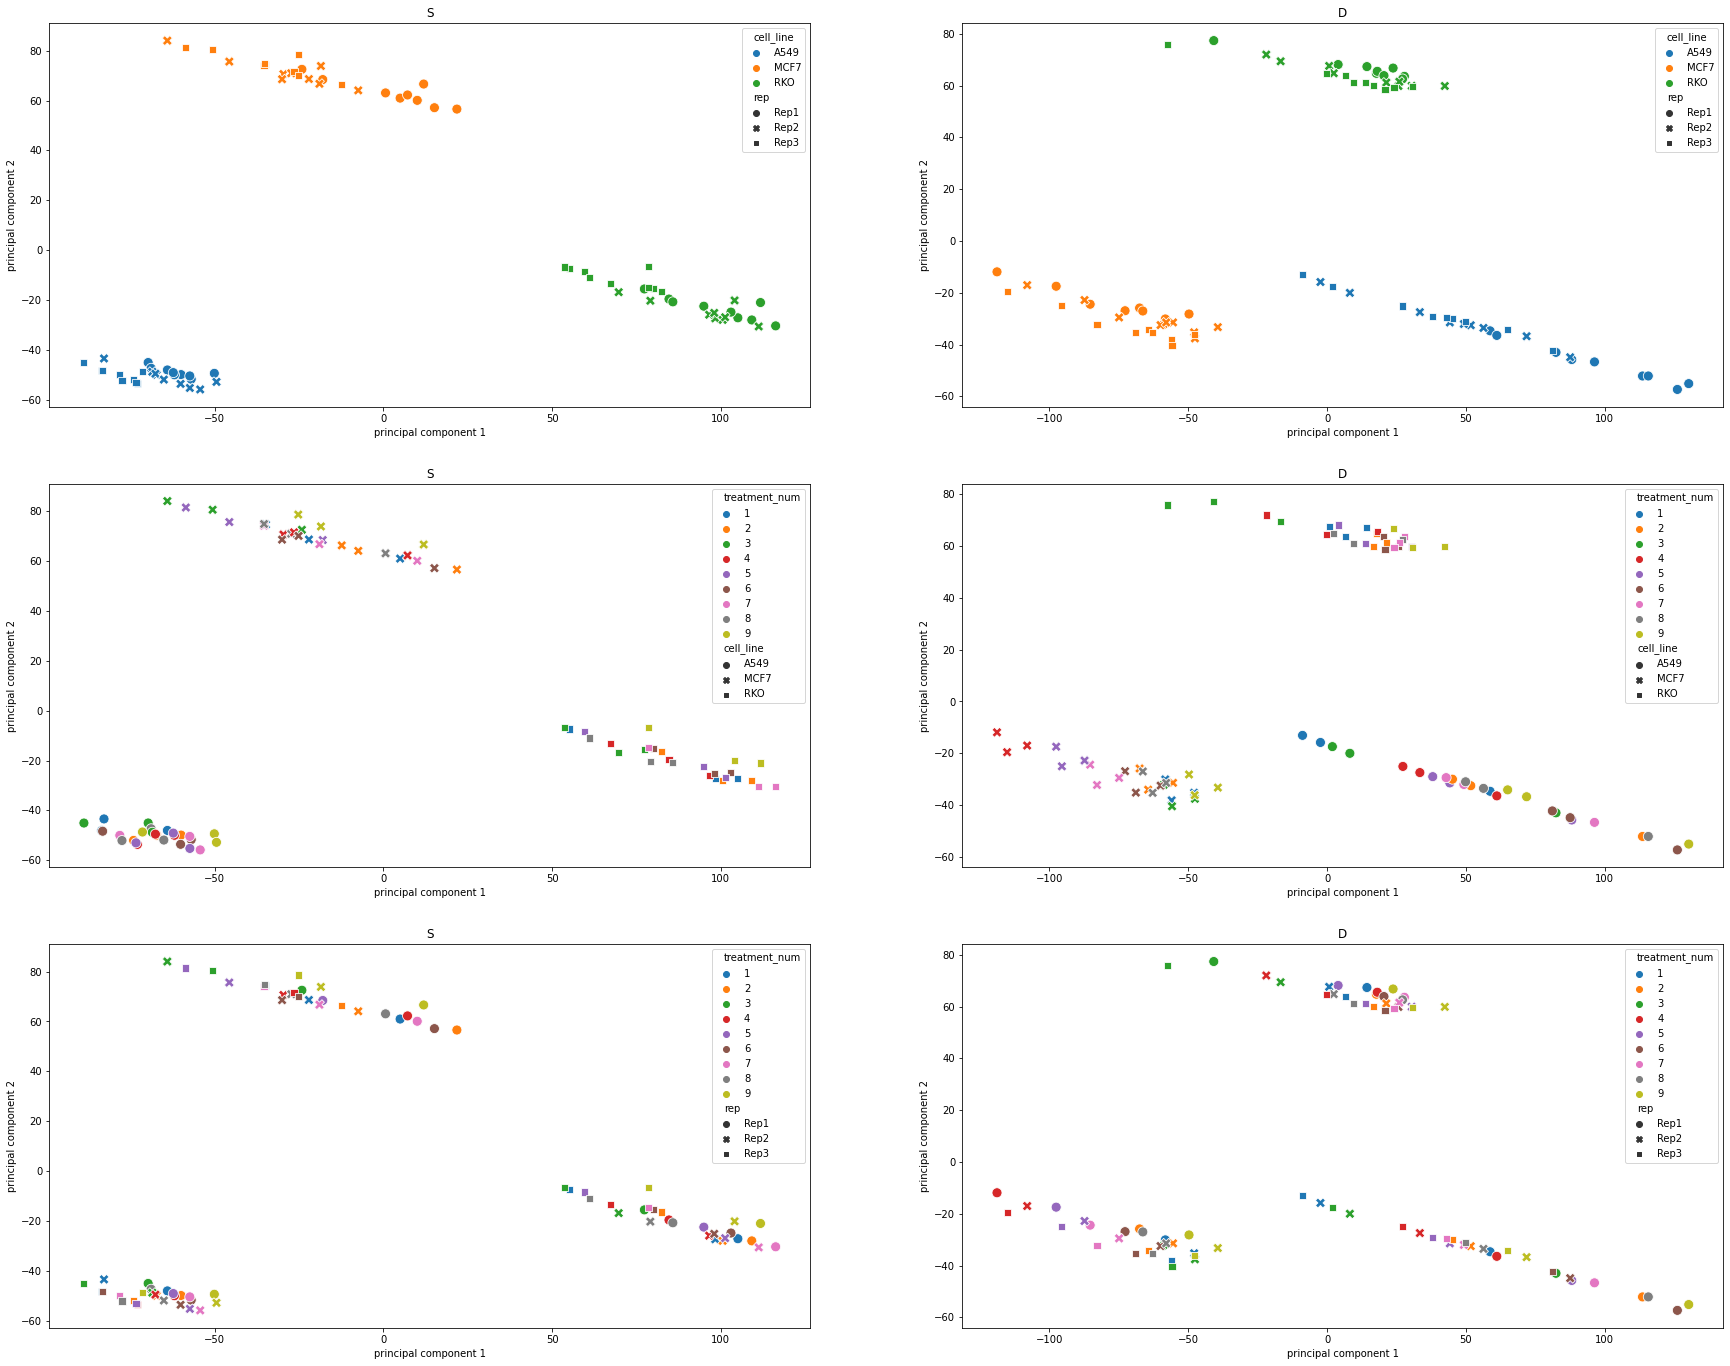

In [31]:
fig, axes = plt.subplots(3, 2, figsize = (30,24))

states = ["S", "D"]
color_markers = [["cell_line", "rep"], ["treatment_num", "cell_line"], ["treatment_num", "rep"]]
for row in range(3):
    color_marker = color_markers[row]
    for col in range(2):
        state = states[col]
        pca_plot_ax(axes, row, col, df_int, classification = color_marker[0], marker = color_marker[1], seperator = "state",
                    seperate_by = state, title = None)

Clear cell line seperation for surviving cells.

# PCA - dataframe seperated into cell line and state <a name="PCA_cell_line_and_states"></a>

In [39]:

def pca_plot_2sep_ax(axes, row, col, df_int, classification = "state", marker = "rep", sep1 = "cell_line", sep_by1 = "A549",
    sep2 = "state", sep_by2 = "D", title = None):
    
    # splice df_int for pca now
    df_pca = df_int[(df_int[sep1] == sep_by1) & (df_int[sep2] == sep_by2)]
    df_pca = df_pca.fillna(0)
    
    features = df_int_proteins
    
    # Separating out the features
    x = df_pca.loc[:, features].values
    
    # Separating out the target
    # classification = "state # Choose target - treatment, cell_line, state here
    # marker = "rep" #marker
    # y = df_pca.loc[:,[classification]].values
    
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    
    # Missing value impuration
    imputer = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value = 0)
    x = imputer.fit_transform(x)
    
    # pca
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, df_pca[[classification]].reset_index()[classification]], axis = 1)
    if marker != False:
        finalDf = pd.concat([finalDf, df_pca[[marker]].reset_index()[marker]], axis = 1)
        
    #Visualization
    #fig, ax = plt.subplots(figsize=(16,10))
    if marker != False:
        sns.scatterplot(ax=axes[row,col] , data = finalDf, x = "principal component 1", y = "principal component 2", 
                        hue = classification, style = marker, s = 100)
    else:
        sns.scatterplot(ax=axes[row,col], data = finalDf, x = "principal component 1", y = "principal component 2", 
                hue = classification, s = 100)
    axes[row, col].set_title(title)

In [40]:


pca_plot_2sep_ax(axes, row, col, df_int, classification = "state", marker = "rep", sep1 = "cell_line", sep_by1 = "A549",
    sep2 = "state", sep_by2 = "D", title = None)

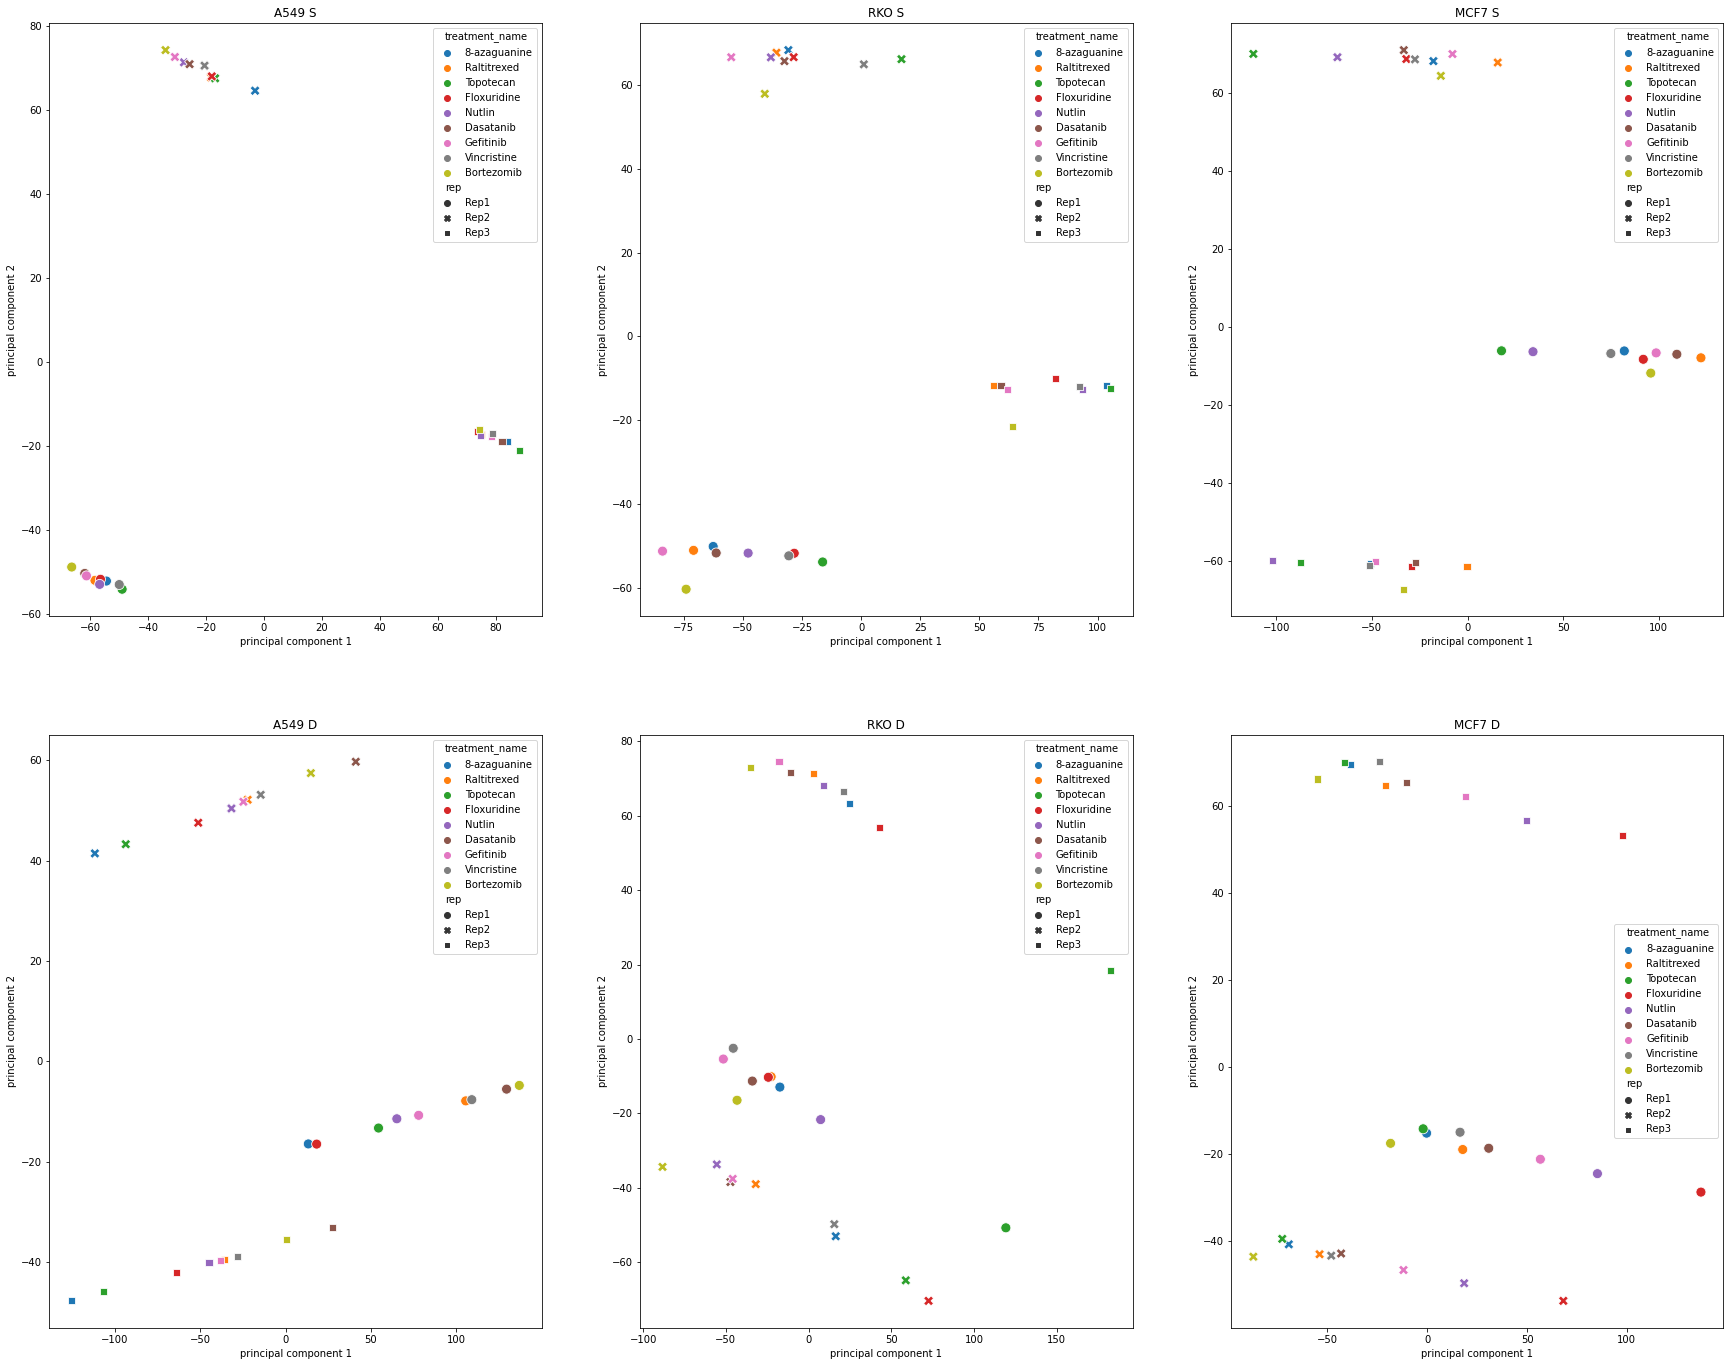

In [41]:
fig, axes = plt.subplots(2, 3, figsize = (30,24))

cell_lines = ["A549", "RKO", "MCF7"]
states = ["S", "D"]

for row in range(len(states)):
    state = states[row]
    for col in range(len(cell_lines)):  
        cell_line = cell_lines[col]
        pca_plot_2sep_ax(axes, row, col, df_int, classification = "treatment_name", marker = "rep", 
                         sep1 = "cell_line", sep_by1 = cell_line,
                         sep2 = "state", sep_by2 = state, title = (cell_line + " " + state))

Replicates seems to be seperated into three replicate groups. This shows batch effects.

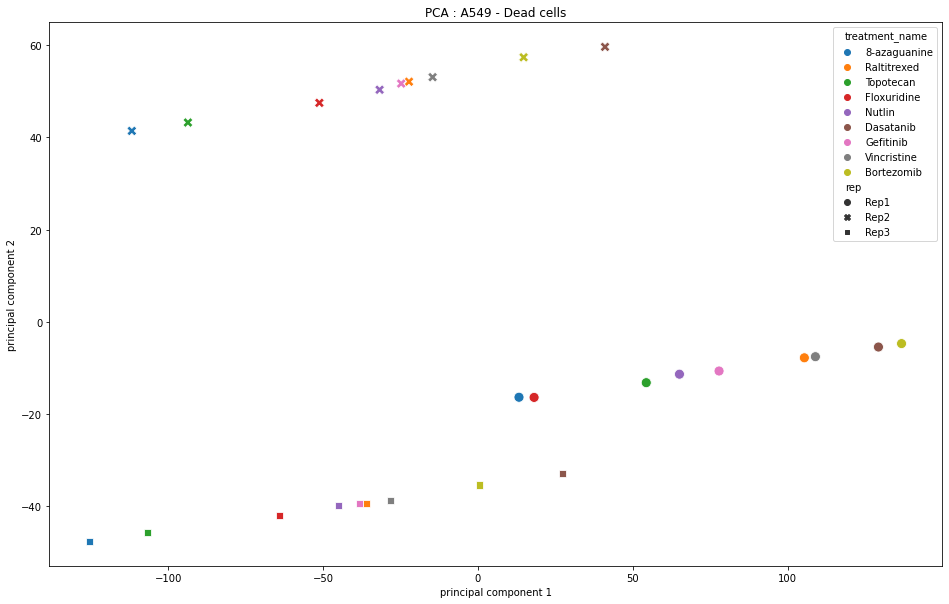

In [206]:
pca_plot_2sep(df_int, classification = "treatment_name", marker = "rep", sep1 = "cell_line", sep_by1 = "A549",
            sep2 = "state", sep_by2 = "D", title = "PCA : A549 - Dead cells")

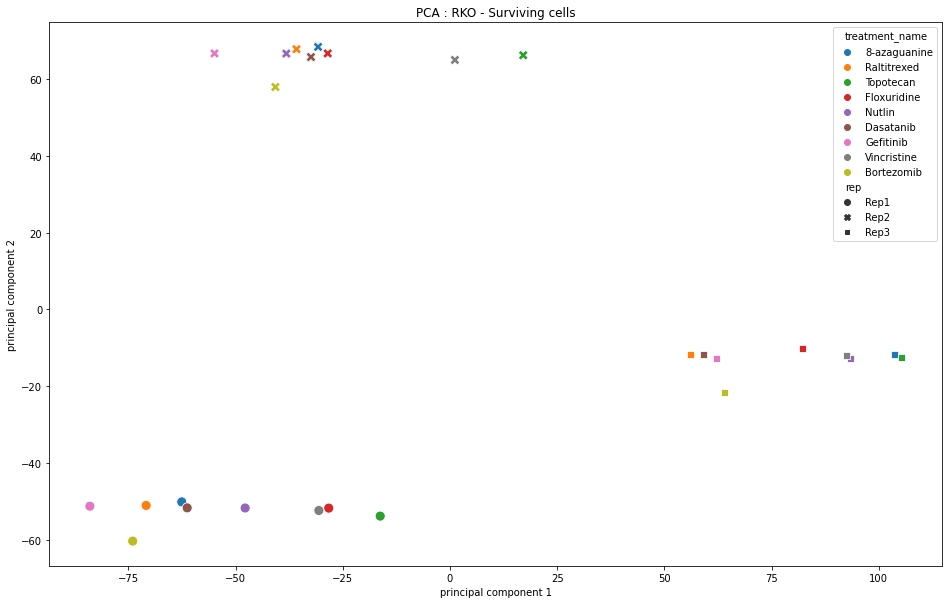

In [207]:
pca_plot_2sep(df_int, classification = "treatment_name", marker = "rep", sep1 = "cell_line", sep_by1 = "RKO",
            sep2 = "state", sep_by2 = "S", title = "PCA : RKO - Surviving cells")

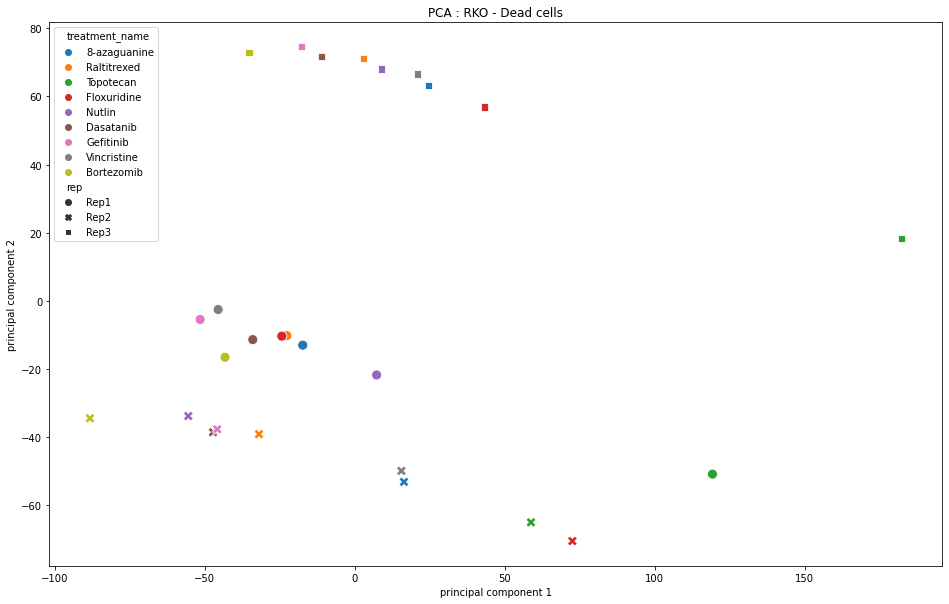

In [208]:
pca_plot_2sep(df_int, classification = "treatment_name", marker = "rep", sep1 = "cell_line", sep_by1 = "RKO",
            sep2 = "state", sep_by2 = "D", title = "PCA : RKO - Dead cells")

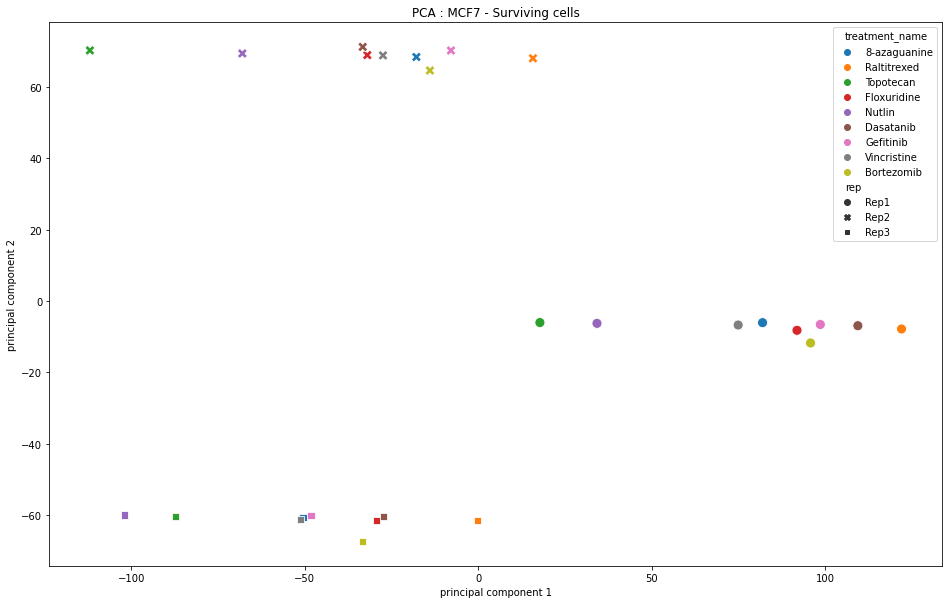

In [209]:
pca_plot_2sep(df_int, classification = "treatment_name", marker = "rep", sep1 = "cell_line", sep_by1 = "MCF7",
            sep2 = "state", sep_by2 = "S", title = "PCA : MCF7 - Surviving cells")

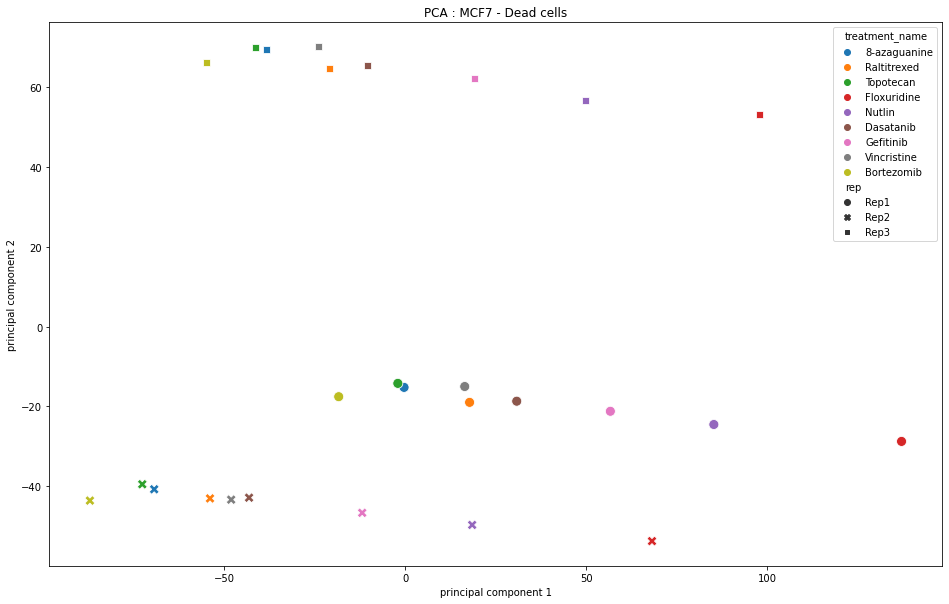

In [210]:
pca_plot_2sep(df_int, classification = "treatment_name", marker = "rep", sep1 = "cell_line", sep_by1 = "MCF7",
            sep2 = "state", sep_by2 = "D", title = "PCA : MCF7 - Dead cells")

Groups are seperated based on replicates. This shows that there are batch effect since the groups should be similar. 

Notes: Attempts at implementing wPCA:
- wpca from wpca module is very slow
- pca with weights for values for statsmodels pca requires NaN imputation before filling setting weights 


# Batch effect investigation <a name="Batch_effect_investigation"></a>

In [156]:
df_int
features = df_int_proteins

# Separating out the features
x = df_int.loc[:, features].values


In [315]:
def plot_triplicate_intensity_histogram(cell_line = "A549", state = "S", treatment_num = "1"):
    df_set = df_int[(df_int.cell_line == "A549") & (df_int.state == "S") & (df_int.treatment_num == str(treatment_num)) ]
    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(len(df_set.index)):
        stacked = pd.DataFrame(df_set.loc[:, features].iloc[i])
        ax.hist(stacked.stack(), bins = 100, alpha = 0.5, label = stacked.columns[0])
    plt.legend()
    plt.show()

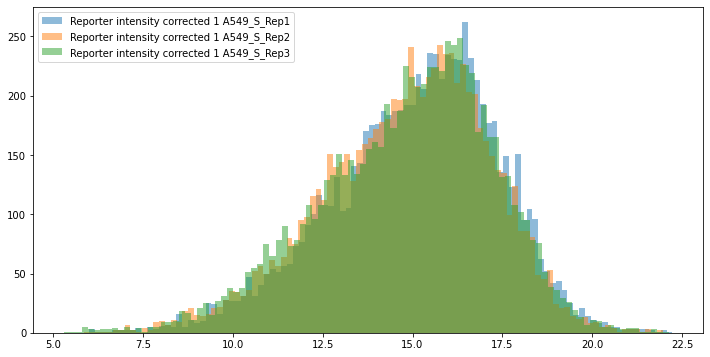

In [316]:
plot_triplicate_intensity_histogram(cell_line = "A549", state = "S", treatment_num = "1")

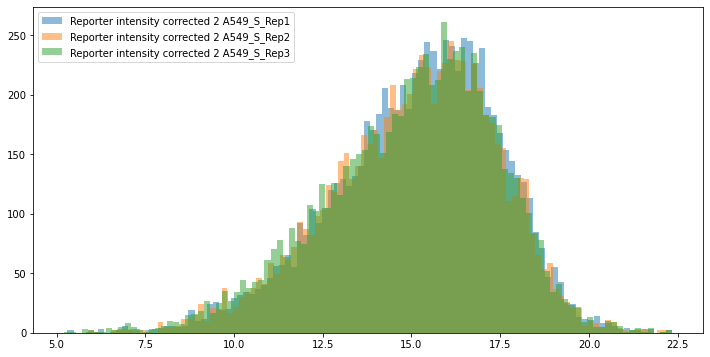

In [317]:
plot_triplicate_intensity_histogram(cell_line = "A549", state = "S", treatment_num = "2")

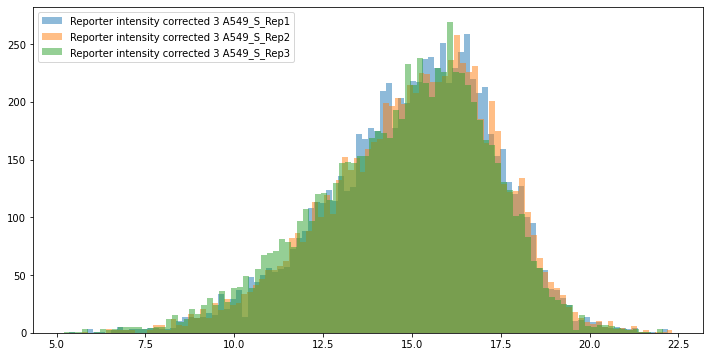

In [318]:
plot_triplicate_intensity_histogram(cell_line = "A549", state = "S", treatment_num = "3")

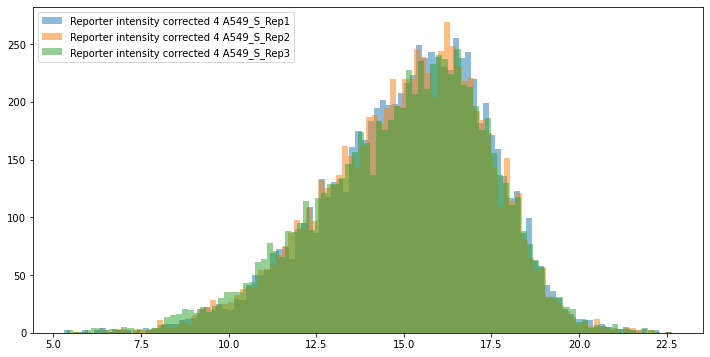

In [319]:
plot_triplicate_intensity_histogram(cell_line = "A549", state = "S", treatment_num = "4")

In [305]:

def plot_histograms(cell_line = "A549", state = "S"):
    fig, axs = plt.subplots(3, 3, figsize = (20,16))

    i = 0
    for row in range(3):
        for col in range(3):
            i += 1
            df_set = df_int[(df_int.cell_line == "A549") & (df_int.state == "S") & (df_int.treatment_num == str(i))]
            for j in range(len(df_set.index)):
                stacked = pd.DataFrame(df_set.loc[:, features].iloc[j])
                axs[row,col].hist(stacked.stack(), bins = 100, alpha = 0.5, label = stacked.columns[0])
                axs[row, col].set_title(cell_line +  " " + state + " " + str(i))
    


# Intensity histogram<a name="Intensity_histogram"></a>

Histograms of the stacked intensities for each experiment. Each 3x3 plot consist of plots of one cell line and state and 3 replicates. Treatments are plotted as seperate plots. Title text has format {cell_line}_ {state} _{treatment_number}.


# Intensity histrogram - A549 Surviving cells <a name="Intensity_histogram_A549_surviving_cells"></a>


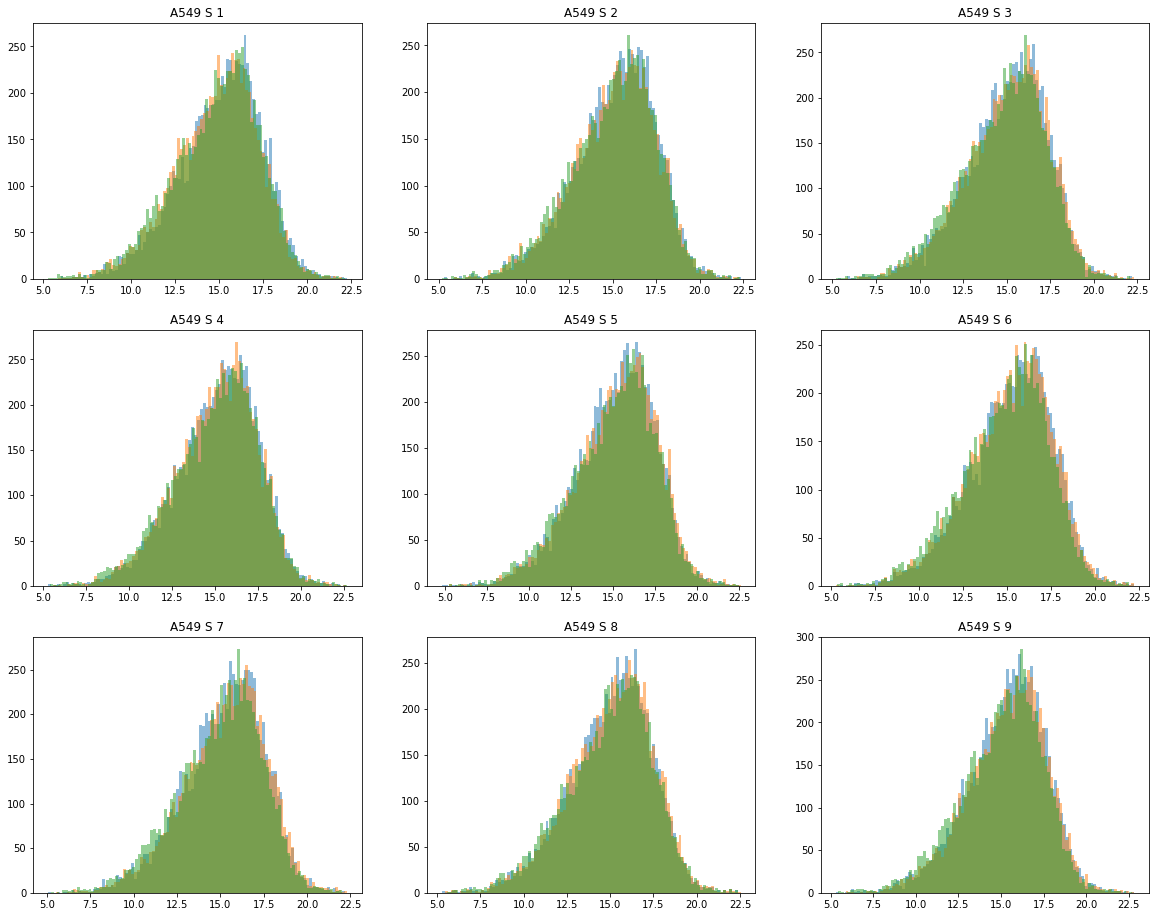

In [306]:
plot_histograms(cell_line = "A549", state = "S")

# Intensity histrogram - A549 dead cells <a name="Intensity_histogram_A549_dead_cells"></a>


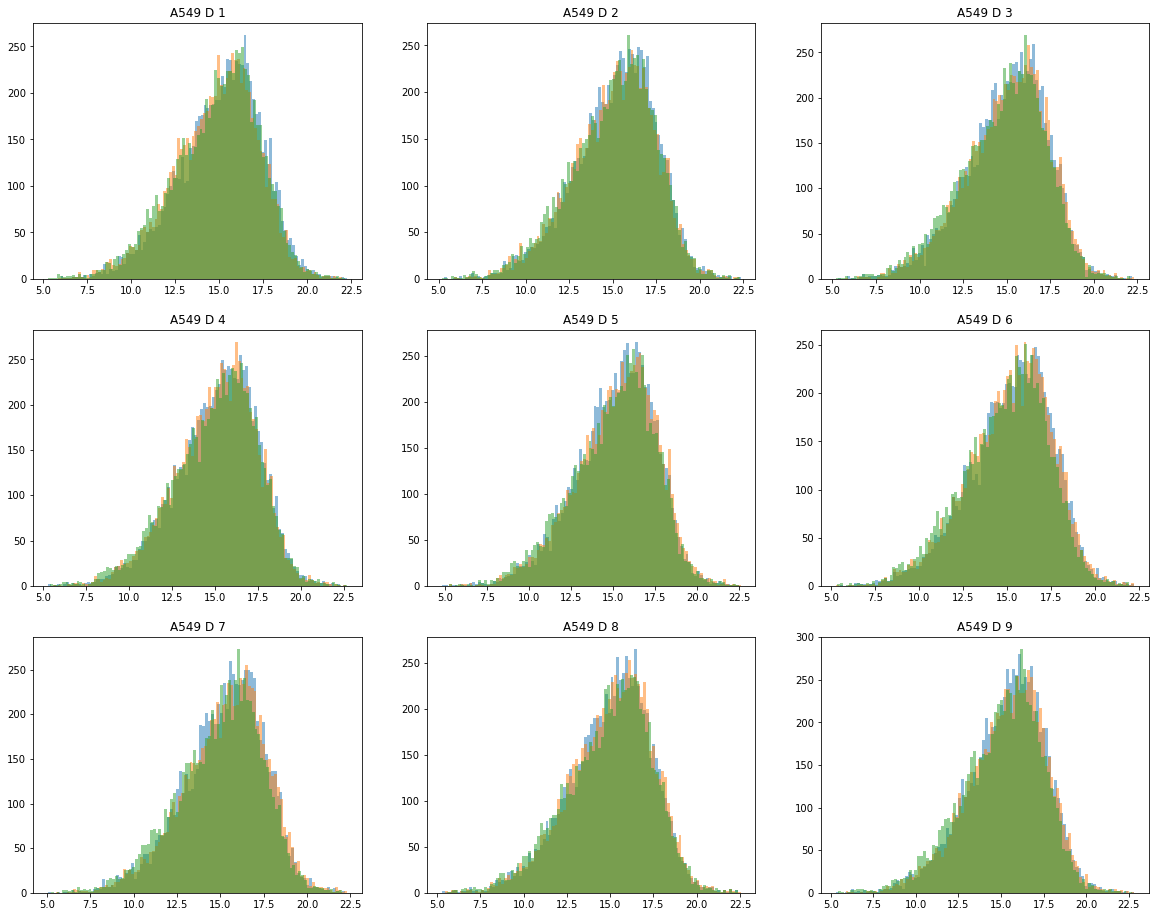

In [307]:
plot_histograms(cell_line = "A549", state = "D")

# Intensity histrogram - RKO surviving cells <a name="Intensity_histogram_RKO_surviving_cells"></a>


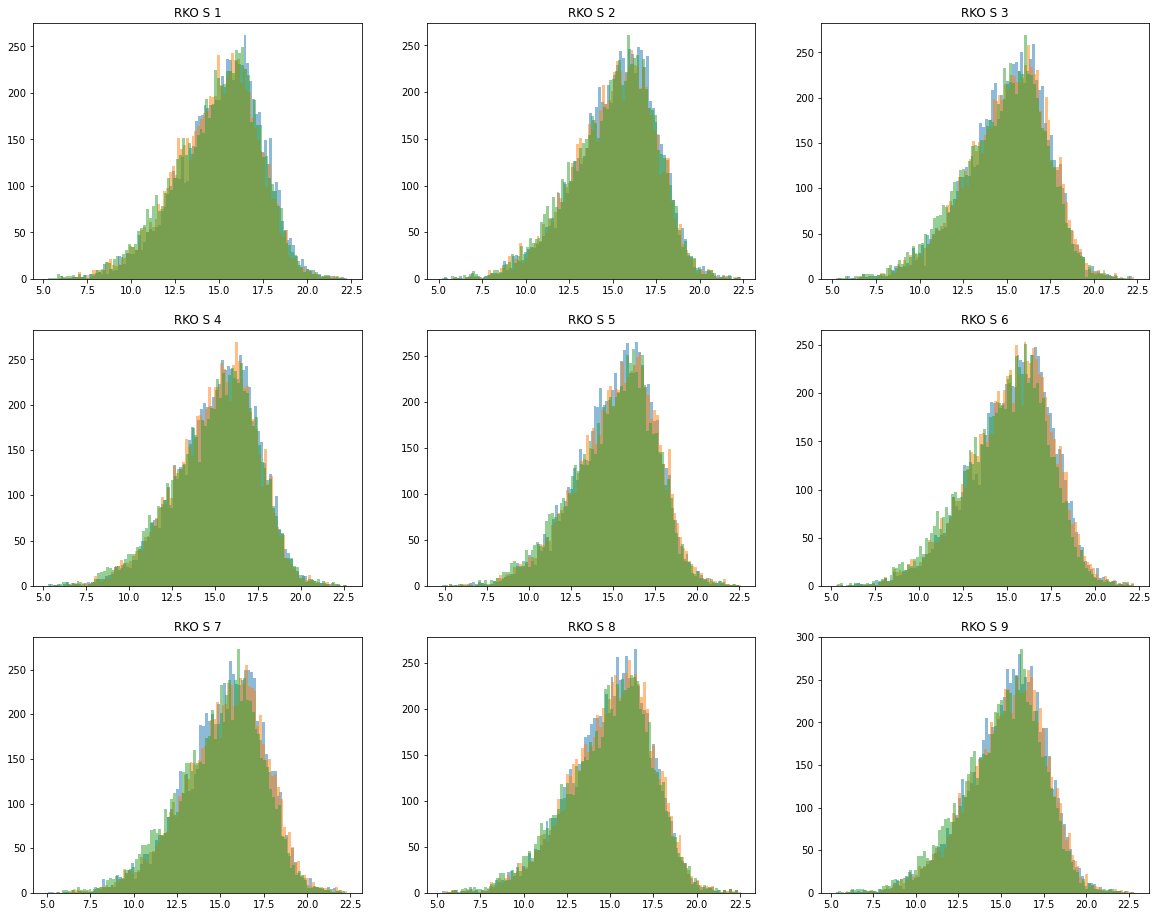

In [309]:
plot_histograms(cell_line = "RKO", state = "S")

# Intensity histrogram - RKO dead cells <a name="Intensity_histogram_RKO_dead_cells"></a>


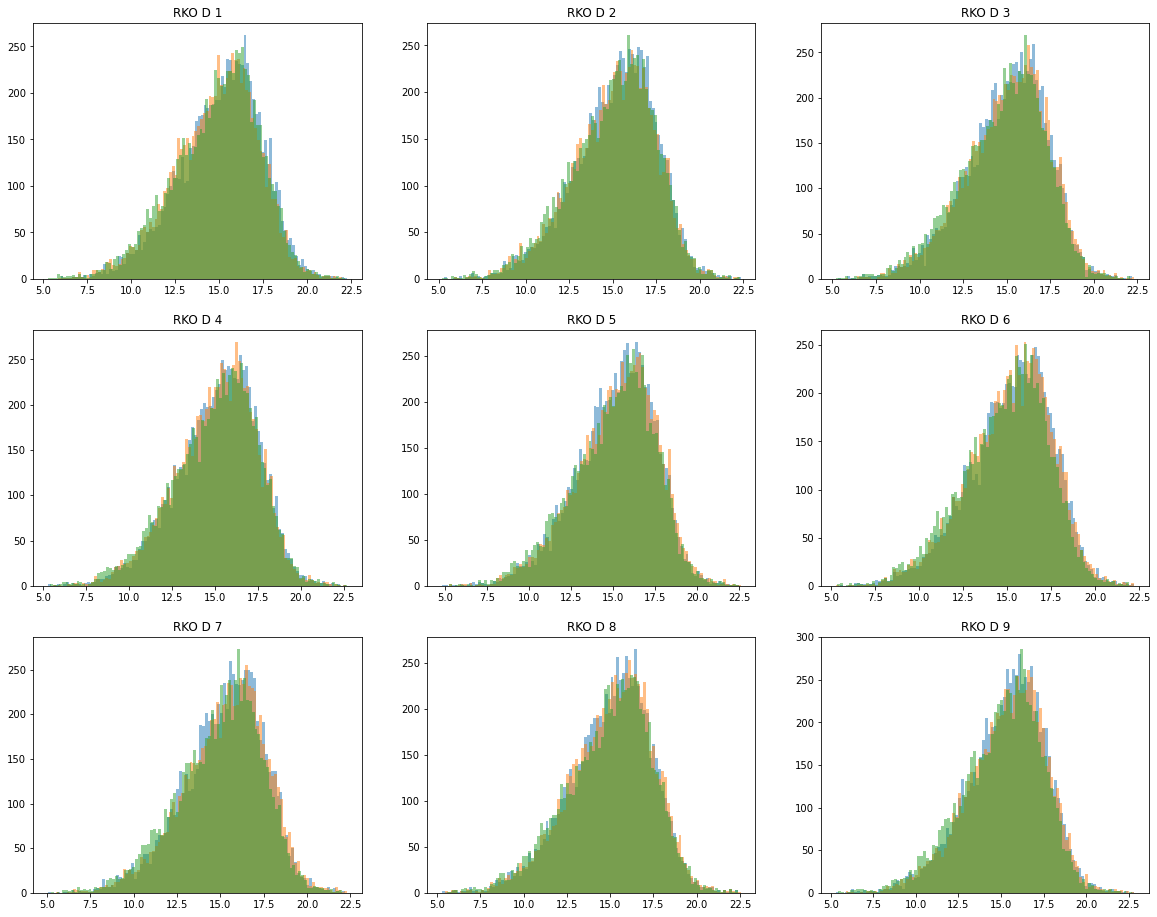

In [310]:
plot_histograms(cell_line = "RKO", state = "D")

# Intensity histrogram - MCF7 surviving cells <a name="Intensity_histogram_MCF7_surviving_cells"></a>


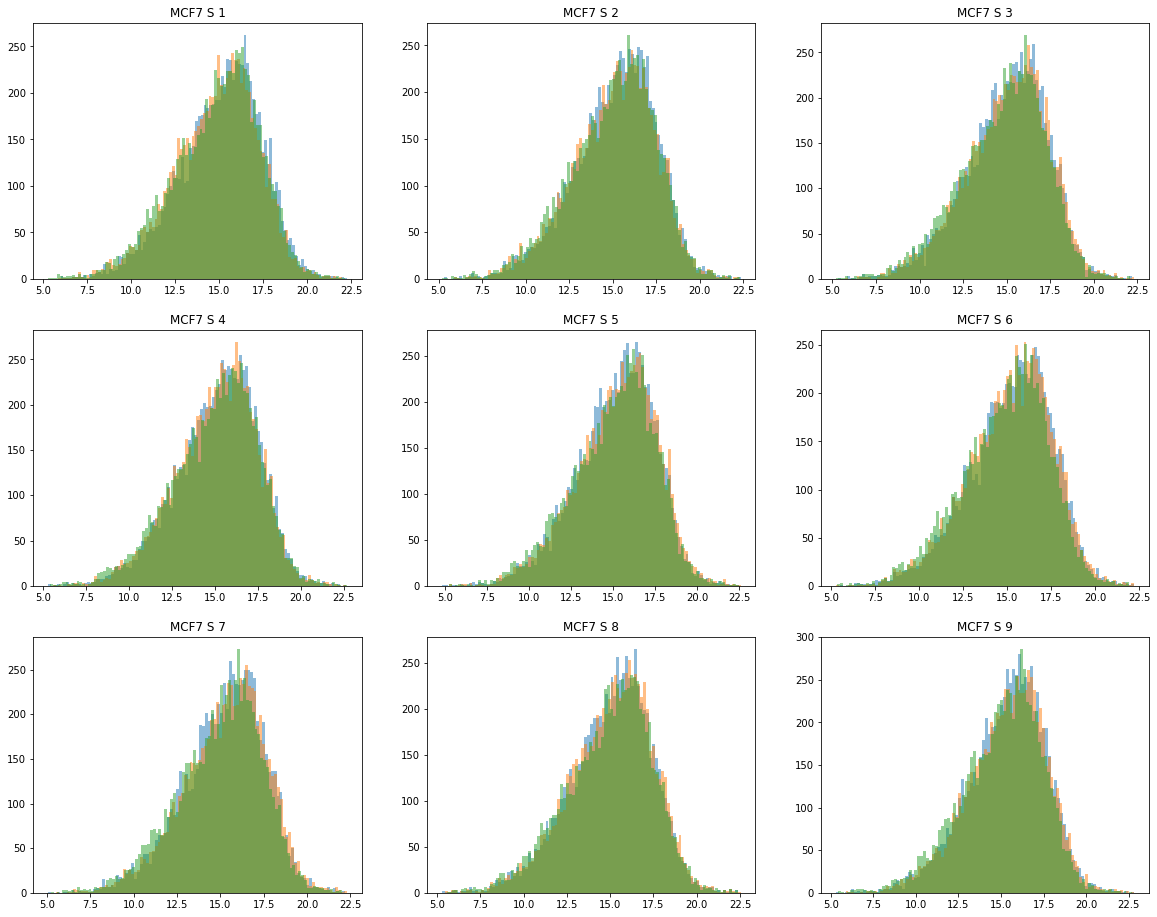

In [311]:
plot_histograms(cell_line = "MCF7", state = "S")

# Intensity histrogram - MCF7 dead cells <a name="Intensity_histogram_MCF7_dead_cells"></a>


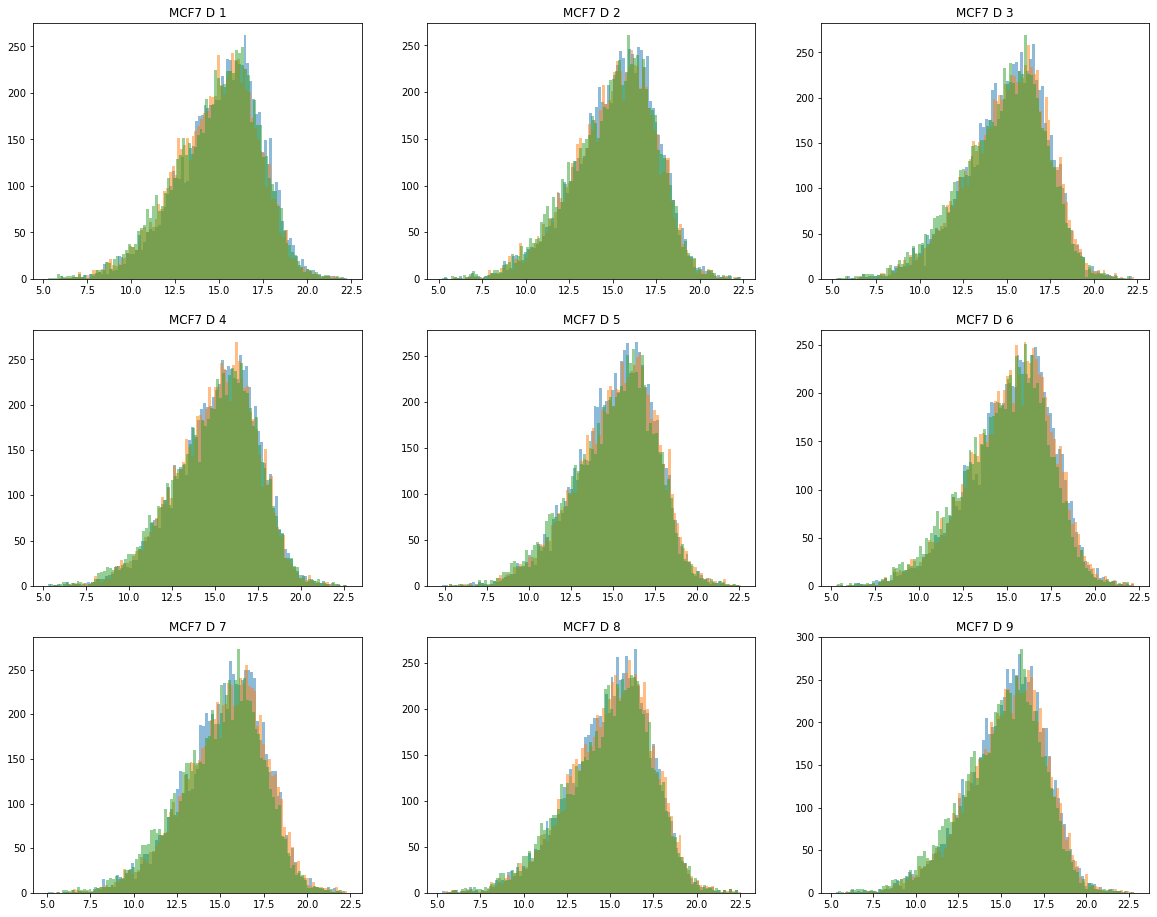

In [312]:
plot_histograms(cell_line = "MCF7", state = "D")